In [7]:
# Import python modules
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time
import pprint
import sys

#import linkage_tools
from linkage_tools import *
from Probabilistic import *
from Perceptron import *

'''
from NeuralNetwork import *
'''

l = Linker()

import warnings
warnings.filterwarnings('error')

### Define linking variables

In [8]:
# Define tables
tableA = '''patient_discharges JOIN newborns
ON patient_discharges.id = newborns.patient_discharge_id
LEFT OUTER JOIN patient_payers AS newborn_payers
ON newborn_payers.patient_discharge_id = patient_discharges.id'''

tableB = '''births JOIN deliveries 
ON births.delivery_id = deliveries.id
JOIN patient_discharges AS delivery_discharges
ON deliveries.patient_discharge_id = delivery_discharges.id
LEFT OUTER JOIN patient_payers AS delivery_payers
ON delivery_payers.patient_discharge_id = delivery_discharges.id'''

# Define fields to compare tables by
tableA_fields = ['patient_discharges.sex_id','newborns.id','newborns.cesarean_section', 
            'patient_discharges.zip_code','patient_discharges.race_id','patient_discharges.ethnicity_id', 
                'newborn_payers.payer_type_of_coverage_id','patient_discharges.principal_language_spoken', 
                 'patient_discharges.discharged_on','newborn_payers.payer_category_id',
                 'newborn_payers.plan_code_number','newborns.birth_weight_group_id',
                 'newborns.gestational_age_group_id','newborns.plurality_group_id']

tableB_fields = ['births.sex_id','births.newborn_id','births.delivery_route_id', 
            'births.mothers_residence_zip_code','delivery_discharges.race_id','delivery_discharges.ethnicity_id', 
                'delivery_payers.payer_type_of_coverage_id','delivery_discharges.principal_language_spoken', 
                 'delivery_discharges.discharged_on','delivery_payers.payer_category_id',
                 'delivery_payers.plan_code_number','births.birth_weight',
                 'births.gestational_age_ob_estimate','births.plurality'] 

feature_vals = ['sex_id','c_section','zip_code','race','ethnicity','payer_type_of_coverage_id',
                'language_spoken','discharge','payer_category_id','plan_code_number','weight_group_id',
                'gest_age_group_id','weight_plus','weight_minus','plurality'] 

# Define bins to use for certain fields
age_bins = np.concatenate(([1,24], np.arange(25, 36, 2),[99]), axis=0)
bw_bins = np.concatenate(([1], np.arange(500, 2001, 250),[2500,9999]), axis=0)
    
# Define conditions (expressions) on which to compare fields
conditions = [  "cross_table['sex_id_x']==cross_table['sex_id_y']",
                "cross_table['cesarean_section']==cross_table['delivery_route_id']",
                "cross_table['zip_code']==cross_table['mothers_residence_zip_code']",
                "cross_table['race_id_x']==cross_table['race_id_y']",
                "cross_table['ethnicity_id_x']==cross_table['ethnicity_id_y']",
                "cross_table['payer_type_of_coverage_id_x']==cross_table['payer_type_of_coverage_id_y']",
                "cross_table['principal_language_spoken_x']==cross_table['principal_language_spoken_y']",
                "cross_table['discharged_on_x']==cross_table['discharged_on_y']",
                "cross_table['payer_category_id_x']==cross_table['payer_category_id_y']",
                "cross_table['plan_code_number_x']==cross_table['plan_code_number_y']",
                "cross_table['birth_weight_group_id']==np.digitize(list(cross_table['birth_weight']),bw_bins)",
                "cross_table['gestational_age_group_id']==np.digitize(list(cross_table['gestational_age_ob_estimate']/7),age_bins)+1",
                "cross_table['birth_weight_group_id']==np.digitize(list(cross_table['birth_weight']),bw_bins)+1",
                "cross_table['birth_weight_group_id']==np.digitize(list(cross_table['birth_weight']),bw_bins)-1",
                "cross_table['plurality_group_id']==cross_table['plurality']"   ] 

simple_features = feature_vals[0:12]
#complex_features = feature_vals[12:]

learning_rate = 0.01 # small, constant learning rate for perceptron

# Create instances of learners
pr_simple = Probabilistic(len(simple_features)) # probabilistic linkage (simple features only)
pr_complex = Probabilistic(len(conditions)) # probabilistic linkage (all features)

pt_simple = Perceptron(len(simple_features),learning_rate) # single-layer perceptron (simple features only)
pt_complex = Perceptron(len(conditions),learning_rate) # single-layer perceptron (all features)


# n = l.neuralNetwork(input_nodes,hidden_nodes,output_nodes,learning_rate) # multi-layer neural network

verbose = True

### Blocking

In [9]:
"""
# Find relative frequencies of values in each field
# - save each as dictionary (1 dict per field per table)
rel_freq_tA = {}

for i in tableA_fields:

    stmt = '''SELECT {0} value, COUNT(*) count
    FROM {1}
    GROUP BY {0};'''.format(i,tableA)

    field_dict = exec_statement(stmt,'dict')
    rel_freq_tA[i] = dict(zip(field_dict['value'],field_dict['count']))
    
rel_freq_tB = {}
for i in tableB_fields:

    stmt = '''SELECT {0} value, COUNT(*) count
    FROM {1}
    GROUP BY {0};'''.format(i,tableB)

    field_dict = exec_statement(stmt,'dict')
    rel_freq_tB[i] = dict(zip(field_dict['value'],field_dict['count']))
"""
    
# Find all possible values for 1st blocking field ('hospital_id')
stmt = '''
SELECT DISTINCT patient_discharges.hospital_id
FROM patient_discharges 
UNION
SELECT DISTINCT births.hospital_id
FROM births;'''
block_list1 = [x[0] for x in l.exec_sql(stmt).values.tolist()]

block_list1 = block_list1[0:4]

# Find all possible values for 2nd blocking field ('date_of_delivery')
stmt = '''
SELECT DISTINCT births.date_of_delivery
FROM births;'''
block_list2 = [x[0] for x in l.exec_sql(stmt).values.tolist()]

block_list2 = block_list2[500:699]

block_prod = [(str(x),str(y)) for x in block_list1 for y in block_list2]

### Iterate over each block
- Create each block and export to python pandas dataframe
- Cross join the features-of-interest from both blocks (dataframes)
- Other stuff...
- Maximize match score with Kuhn-Munkres (i.e. Hungarian) Algorithm [more info]

[more info]: https://pypi.python.org/pypi/munkres/

In [10]:
# tss_iter_list = []
iter_qual_list = []
duration = [] # for timer
prev_iter_qual = 0.0 # for breaking link-iteration loop
link_iter = 0
verb_str = '\r Iter. #{}, blockA: {} records, blockB: {} records  ' # verbose output

while True:

    big_bool = pd.DataFrame(columns=feature_vals)

    #tss = 0.0 # total sum-squared error

    for block1, block2 in block_prod:
        
        start = time.time() # Measure loop iteration duration

        # Create 'blockA'
        stmt1 = '''
        SELECT patient_discharges.id AS pdd_id, newborns.id AS newb_id,%s 
        FROM %s
        WHERE patient_discharges.hospital_id = %r
        AND patient_discharges.date_of_birth = %r;
        ''' % (",".join(tableA_fields),tableA,block1,block2)
        blockA = l.exec_sql(stmt1)

        # Create 'blockB'
        stmt2 = '''
        SELECT births.id AS bc_id,%s
        FROM %s
        WHERE births.hospital_id = %r
        AND births.date_of_delivery = %r;
        ''' % (",".join(tableB_fields),tableB,block1,block2)
        blockB = l.exec_sql(stmt2)
        
        if verbose:
            # Print on each iteration
            sys.stdout.write(verb_str.format(link_iter+1, len(blockA), len(blockB)))
            sys.stdout.flush() 
        
        # Check that neither block is empty - If empty, skip to next record-pair iteration in loop
        if (len(blockA)==0) or (len(blockB)==0):
            continue

        # Cross-join both blocks
        cross_table = l.df_crossjoin(blockA, blockB)

        # Count field matches and dump each into new column of dataframe
        bool_table = pd.DataFrame.from_items(zip(feature_vals,[eval(x).values for x in conditions]))

        # Add record-id columns to boolean table
        bool_table['newb_id'] = cross_table['newb_id'].values # Actual newborn id
        bool_table['bc_id'] = cross_table['bc_id'].values  # Actual bc id

        # Compare with previously-linked newborn id
        bool_table['real_match'] = (cross_table['newborn_id']==cross_table['newb_id']).values 
        bool_table['match'] = False # Create new column for later
        bool_table['match_simple'] = False # Create new column for later
        bool_table['match_perc'] = False # Create new column for later
        bool_table['match_perc_simple'] = False # Create new column for later

        # Get guesses from learners
        links_ind,link_score = pr_simple.query(bool_table[simple_features],bool_table[['newb_id','bc_id']])
        bool_table['link_score_simple'] = link_score
        bool_table.loc[links_ind,'match_simple'] = True
        
        links_ind,link_score = pr_complex.query(bool_table[feature_vals],bool_table[['newb_id','bc_id']])
        bool_table['link_score'] = link_score
        bool_table.loc[links_ind,'match'] = True # Label nominees as such        
  
        links_ind,link_score = pt_simple.query(bool_table[simple_features],bool_table[['newb_id','bc_id']])
        bool_table['link_score_perc_simple'] = link_score
        bool_table.loc[links_ind==1,'match_perc_simple'] = True # Label nominees as such 
        
        links_ind,link_score = pt_complex.query(bool_table[feature_vals],bool_table[['newb_id','bc_id']])
        bool_table['link_score_perc'] = link_score
        bool_table.loc[links_ind==1,'match_perc'] = True # Label nominees as such         
        
        # Train perceptron immediately
        pt_complex.train(bool_table[feature_vals],bool_table['real_match'],bool_table[['newb_id','bc_id']])
        pt_simple.train(bool_table[simple_features],bool_table['real_match'],bool_table[['newb_id','bc_id']])
        
        # Aggregate field-match tables (Booleans) within loop
        big_bool = pd.concat([big_bool,bool_table])

        # Time duration of each iteration
        duration.append(time.time()-start)

    # Train learners
    pr_complex.train(big_bool[feature_vals],big_bool['match'])
    pr_simple.train(big_bool[simple_features],big_bool['match_simple'])
    
    # Get range of linkage scores (0 through 100 percentiles) i.e. decision threshold (theta)
    theta = np.percentile(big_bool['link_score'].loc[big_bool['real_match']],range(0,100,10))
    precision,recall = pr_complex.prec_recall(big_bool['link_score'],theta,big_bool['real_match']) # Measure precision & recall
    pr_complex.prec_list.append(precision)
    pr_complex.recall_list.append(recall)
    #tss_iter_list.append(tss)

    cur_iter_qual = abs(np.nanmean(precision) + np.nanmean(recall))
    iter_qual_list.append(cur_iter_qual)

    # Compare current iteration with previous iterations
    if abs(cur_iter_qual-prev_iter_qual)<.01: # If not improving
        print str.format("\n'Quality' achieved! @ {}",cur_iter_qual)
        break # Break outer loop
    else:
        prev_iter_qual = cur_iter_qual # Update comparative value

    if verbose:
        #print '\n',pd.DataFrame([m_probs, u_probs, weights],index=['m_probs', 'u_probs', 'weights'])
        print str.format('\n Average block loop iteration duration: {0:.2f} seconds', sum(duration) / len(duration))
        if 'prev_iter_qual' in locals():
            print str.format(" 'Quality' of prev. iter.: {}", prev_iter_qual)

    link_iter += 1 # Increment while loop iterator


 Iter. #1, blockA: 5 records, blockB: 7 records    
 Average block loop iteration duration: 0.11 seconds
 'Quality' of prev. iter.: 80.9239618467
 Iter. #2, blockA: 5 records, blockB: 7 records    
 Average block loop iteration duration: 0.12 seconds
 'Quality' of prev. iter.: 93.1756938559
 Iter. #3, blockA: 5 records, blockB: 7 records    
 Average block loop iteration duration: 0.12 seconds
 'Quality' of prev. iter.: 98.1095516608
 Iter. #4, blockA: 5 records, blockB: 7 records    
'Quality' achieved! @ 98.1095516608


In [5]:
print zip(feature_vals+['bias'], pt_complex.weights)
#print zip(feature_vals, pr_complex.m_probs)

[('sex_id', 0.035248934028042654), ('c_section', 0.0084613682905137991), ('zip_code', 0.0048175788252125852), ('race', 0.0089382867367311641), ('ethnicity', -0.0074055543852463981), ('payer_type_of_coverage_id', -0.00088212261050232658), ('language_spoken', -0.0049806387772226325), ('discharge', 0.021466504811981417), ('payer_category_id', 0.0048452441103974207), ('plan_code_number', 0.0085713430483663113), ('weight_group_id', 0.025344143125289209), ('gest_age_group_id', 0.0049578724336278249), ('weight_plus', -0.0010502996446108831), ('weight_minus', -0.0064337983734782233), ('plurality', 0.020131434838240349), ('bias', 0.00025072318537588956)]


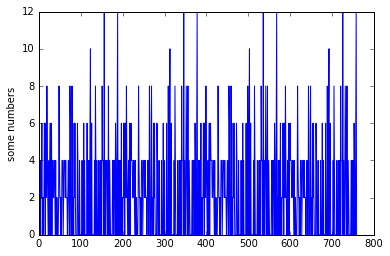

In [6]:
plt.plot(pt_complex.tss)
plt.ylabel('some numbers')
plt.show()

In [11]:
inputs_list = bool_table[feature_vals]
predictions,score = pt_complex.query(inputs_list)
targets = np.array(bool_table['match'], ndmin=2)

inputs = np.array(inputs_list, ndmin=2)
inputs = np.concatenate((inputs,np.repeat(1, len(inputs[:,1]))[:, None]), axis=1) # Add bias input
weights = np.random.uniform(low=-0.01, high=0.01, size=len(inputs[1,:]))
    
output_errors = targets-predictions
print output_errors
#print inputs.shape,weights.shape,output_errors.shape

#print learning_rate * np.dot(output_errors, inputs)

for i,row in enumerate(inputs):
    foo = output_errors[:,i] * row
    weights += learning_rate * output_errors[:,i] * row
#print weights

[[ 0.  0.  0.  0. -1.  0.  0. -1.  0. -1. -1. -1. -1. -1. -1.  0.]]


In [7]:
bool_table
#bool_table[feature_vals].apply(prob_link, axis=1, features=feature_vals[simple_features])
#complex_features
# bool_table[feature_vals[simple_features]].apply(prob_link, axis=1)

,c_section,discharge,ethnicity,gest_age_group_id,language_spoken,payer_category_id,payer_type_of_coverage_id,plan_code_number,race,sex_id,...,weight_minus,weight_plus,zip_code,newb_id,bc_id,real_match,pair_match,linkage_score,linkage_score_simple,linkage_cost
0,False,False,False,False,False,True,False,False,False,False,...,True,False,False,19440,41210,False,True,0.090536,-0.085081,0.017088
1,False,False,False,False,False,False,False,False,False,False,...,True,False,False,19440,41211,False,False,-0.113201,0.106381,0.220825
2,False,False,False,False,False,True,True,False,False,False,...,True,False,False,19440,41212,False,False,-0.047231,0.044385,0.154855
3,False,False,False,False,False,False,False,False,False,False,...,True,False,False,19440,41218,False,False,-0.113201,0.106381,0.220825
4,False,False,False,False,False,True,True,False,False,False,...,True,False,False,19440,41219,False,False,-0.047231,0.044385,0.154855
5,False,False,False,False,False,False,False,False,False,False,...,False,False,False,17789,41210,False,False,0.107624,0.106381,0.000000
6,False,False,False,False,False,False,False,False,False,False,...,False,False,False,17789,41211,False,False,0.107624,0.106381,0.000000
7,False,False,False,False,False,False,False,False,False,False,...,False,False,False,17789,41212,False,False,0.107624,0.106381,0.000000
8,False,False,False,False,False,False,False,False,False,False,...,False,False,False,17789,41218,False,False,0.107624,0.106381,0.000000
9,False,False,False,False,False,False,False,False,False,False,...,False,False,False,17789,41219,False,True,0.107624,0.106381,0.000000


### Plot precision/recall for each iteration of probabilistic record linkage

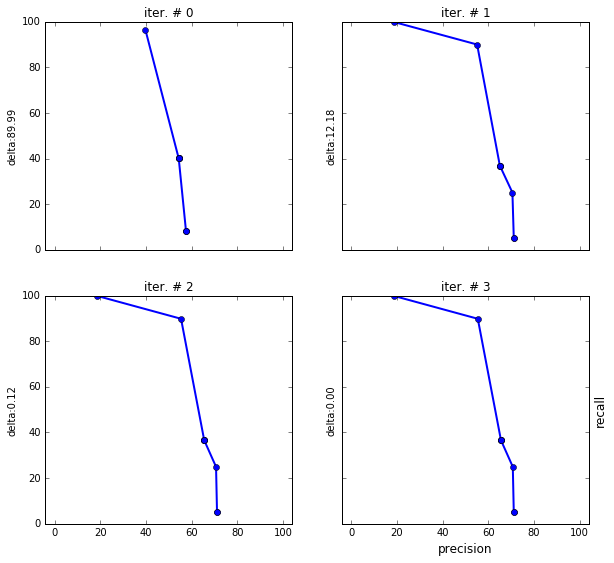

In [7]:
deltas = np.diff([0]+iter_qual_list)

plot_prec = pr_complex.prec_list
plot_recall = pr_complex.recall_list

# row and column sharing
ncol = int(np.ceil(np.sqrt(len(plot_prec))))
nrow = int(np.ceil(len(plot_prec)/float(ncol)))
fig, axs = plt.subplots(nrow, ncol, sharex='col', sharey='row')
for i, ax in enumerate(fig.axes[0:len(plot_prec)]):
    ax.set_xlim([0,100])
    ax.set_ylim([0,100])
    ax.plot(plot_prec[i], plot_recall[i], '-', linewidth=2, marker='o', color='b')
    ax.set_title("iter. # {}".format(str(i)), fontsize=12)
    ax.set_ylabel("delta:{0:3.2f}".format(float(deltas[i])), fontsize=10)
    ax.set(aspect='equal')    
else:
    ax.set_xlabel('precision', fontsize=12)
    ax2 = ax.twinx()
    plt.setp(ax2.get_yticklabels(), visible=False)
    ax2.yaxis.set_label_position("right")
    ax2.set_ylabel('recall', fontsize=12)
    
fig.set_size_inches(4.875*ncol,4.5*nrow)
plt.show()

In [ ]:
bool_table = pd.DataFrame(columns=feature_vals)
for field, cond in zip(feature_vals, conditions):
    cond_res = eval(cond)
    bool_table[field] = cond_res.values
    
print(zip(feature_vals, conditions))

In [11]:
cutoff = theta[-1]
winners = (big_bool['linkage_score']>cutoff)
print sum(winners&big_bool['real_match'])
print sum(winners&big_bool['pair_match']&big_bool['real_match'])
print sum(big_bool['pair_match']&big_bool['real_match'])

# Precision: the percent of pairs with a score above theta that are real matches
# USE ONLY NOMINATED PAIRS
# - numerator: number of NOMINATED pairs with a score above theta that are real matches
real_picks = sum(winners&big_bool['real_match']&big_bool['pair_match'])
# - denominater: number of NOMINATED pairs with a score above theta
picks = sum(winners&big_bool['pair_match'])
precision = (real_picks/float(picks)*100)

# Recall: the percent of known matched pairs that get a score above theta
# - numerator: number of NOMINATED pairs with a score above theta that are real matches
# - denominater: number of pairs that are real matches
real_matches = big_bool['real_match'].sum()
recall = (real_picks/float(real_matches)*100)

print precision,recall

37
32
484
84.2105263158 4.59110473458


In [ ]:

"""
[1,  '< 500g',          1,    1 ..  499, 1],
    [2,  '500 to 749g',     2,  500 ..  749, 1],
    [3,  '750 to 999g',     3,  750 ..  999, 1],
    [4,  '1,000 to 1,250g', 4, 1000 .. 1250, 2],
    [5,  '1,250 to 1,499g', 5, 1250 .. 1499, 2],
    [6,  '1,500 to 1,749g', 6, 1500 .. 1749, 3],
    [7,  '1,750 to 1,999g', 7, 1750 .. 1999, 4],
    [8,  '2,000 to 2,499g', 8, 2000 .. 2499, 5],
    [9,  '> 2,500g',        9, 2500 .. 9999, 6],
    # Overweight?!?
    [11, 'Unknown',         0, []],
"""


data = list(cross_table['birth_weight'])
        
bw_bins = np.concatenate(([1], np.arange(500, 2001, 250),[2500,9999]), axis=0)
print bw_bins

inds = np.digitize(data, bw_bins)

for n in range(len(data)):
    print(bw_bins[inds[n]-1], "<=", data[n], "<", bw_bins[inds[n]])


In [ ]:
data = cross_table['gestational_age_ob_estimate']/7

# '<24 weeks','24 weeks','25-26 weeks','27-28 weeks',...'35-36 weeks','37 or more weeks'
        
bins = np.concatenate(([0,24], np.arange(25, 36, 2),[99]), axis=0)
print bins

inds = np.digitize(data.tolist(), bins)

for n in range(len(data)):
    print(bins[inds[n]-1], "<=", data[n], "<", bins[inds[n]])


### Update 'births' table accordingly

In [ ]:
foo = fin_bool.loc[big_bool['pair_match']==1]
for index, row in foo.iterrows():     
    stmt1 = '''
        UPDATE births 
        SET newborn_id_2 = %d, newborn_linkage_score_2 = %s
        WHERE id = %d;
        ''' % (row['newb_id'], row['linkage_score'], row['bc_id'])
    exec_statement(stmt1)